# Capstone 

## Introduction

In this project I will try to create machine learning model that could predict, does some weather conditions will lead to road accident with the injured. Model of similar type could be used by emergency services for provisional allocation of ambulance teams in specific regions.

In context of this problem False Negative outputs are more unwanted than False Positive, because the cost of FN output may be human life. Therefore I will try to crate **recall-oriented** ML model.


## Data

I will use Seattle city road accidents data. It contain information of severity, location, weather conditions, date, and other details for each case. 

Most of the columns in table such as: 
CROSSWALKKEY(*A key for the crosswalk at which the collision
occurred*), JUNCTIONTYPE(*Category of junction at which collision took place*), SPEEDING, do not have valuable information for my task, so they will be removed from dataset.

Columns such as: **WEATHER, ROADCOND, LIGHTCOND** contains data that will be used as atributes for classification problem my model wil be solving.

**SEVERITYCODE** column can be used as a target values for ML. 

Also the data should be balanced to prevent creation of biased ML model.



In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pixiedust
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
%matplotlib notebook

### Data cleansing

Let's read .csv file and remove data that don't related weather conditions or severity of road accidents.

In [157]:
df=pd.read_csv('Data-Collisions.csv')
df.drop(['PEDCOUNT', 'PEDCYLCOUNT', 'INCKEY', 'OBJECTID',
         'COLDETKEY', 'INTKEY', 'X', 'Y', 'CROSSWALKKEY',
         'SPEEDING', 'HITPARKEDCAR', 'EXCEPTRSNDESC', 'EXCEPTRSNCODE',
        'PEDROWNOTGRNT', 'SDOTCOLNUM', 'LOCATION', 'SDOT_COLDESC',
         'SDOT_COLCODE', 'INATTENTIONIND', 'SEGLANEKEY', 'JUNCTIONTYPE',
        'INCDATE', 'PERSONCOUNT', 'REPORTNO', 'STATUS',
        'UNDERINFL', 'INCDTTM', 'ST_COLDESC'], inplace=True, axis=1)

# Also remove columns that duplicate info about severity. 
df.drop(['SEVERITYCODE.1', 'SEVERITYDESC'], inplace=True, axis=1)
df.head()

C:\Users\Vlad\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SEVERITYCODE,ADDRTYPE,COLLISIONTYPE,VEHCOUNT,WEATHER,ROADCOND,LIGHTCOND,ST_COLCODE
0,2,Intersection,Angles,2,Overcast,Wet,Daylight,10
1,1,Block,Sideswipe,2,Raining,Wet,Dark - Street Lights On,11
2,1,Block,Parked Car,3,Overcast,Dry,Daylight,32
3,1,Block,Other,3,Clear,Dry,Daylight,23
4,2,Intersection,Angles,2,Raining,Wet,Daylight,10


Let's check for NaN values.

In [158]:
nan={}
for col in df.columns:
    length=len(df[df[col].isna()==True])
    nan[col]=length
nan

{'SEVERITYCODE': 0,
 'ADDRTYPE': 1926,
 'COLLISIONTYPE': 4904,
 'VEHCOUNT': 0,
 'WEATHER': 5081,
 'ROADCOND': 5012,
 'LIGHTCOND': 5170,
 'ST_COLCODE': 18}

In [159]:
len(df)

194673

In comparison to total length of DataFrame, amount of columns with NaN values is insignificant. So we can just remove they all.

In [160]:
df.dropna(axis=0, inplace=True)
len(df)

187504

Let's categorize the data

In [161]:
codes=[]
for col in df.columns:
        if type(df.at[1, col]) == type('str'):
            ucats = set(df[col])|{'<unknown>'}
            codes.append(ucats)
            df[col]= pd.Categorical(df[col], 
                                             categories=ucats).fillna('<unknown>').codes
codes
df=df.astype('int64')
df.head()

,SEVERITYCODE,ADDRTYPE,COLLISIONTYPE,VEHCOUNT,WEATHER,ROADCOND,LIGHTCOND,ST_COLCODE
0,2,2,6,2,10,5,5,104
1,1,0,7,2,11,5,2,60
2,1,0,9,3,10,3,5,91
3,1,0,8,3,0,3,5,88
4,2,2,6,2,11,5,5,104


In [162]:
df['SEVERITYCODE'].unique()

array([2, 1], dtype=int64)

As we can see there are just 2 types of severity:
* 1(property damage)
* 2(injury)

So, we have **binary classification problem**.

Let's replace values 1 and 2 to 0 and 1 respectively. This will simplify further evaluation of ML models.

In [163]:
df['SEVERITYCODE']=df['SEVERITYCODE'].replace(to_replace=1, value=0)
df['SEVERITYCODE']=df['SEVERITYCODE'].replace(to_replace=2, value=1)
df.head()

,SEVERITYCODE,ADDRTYPE,COLLISIONTYPE,VEHCOUNT,WEATHER,ROADCOND,LIGHTCOND,ST_COLCODE
0,1,2,6,2,10,5,5,104
1,0,0,7,2,11,5,2,60
2,0,0,9,3,10,3,5,91
3,0,0,8,3,0,3,5,88
4,1,2,6,2,11,5,5,104


In [164]:
df['SEVERITYCODE'].value_counts()

0    130634
1     56870
Name: SEVERITYCODE, dtype: int64

From the output of previous code cell we can conclude that we have unbalanced dataset. This can lead to creation bias ML model. So I'll remove part of rows with SEVERITY 1.

In [189]:
df_sorted=df.sort_values('SEVERITYCODE')
df0=df_sorted.iloc[:56870]
df1=df_sorted.iloc[130634:]
fdf=pd.merge(df1, df0, how='outer')
print(fdf['SEVERITYCODE'].value_counts())
fdf.head()

1    56870
0    56870
Name: SEVERITYCODE, dtype: int64


,SEVERITYCODE,ADDRTYPE,COLLISIONTYPE,VEHCOUNT,WEATHER,ROADCOND,LIGHTCOND,ST_COLCODE
0,1,0,8,1,11,5,5,74
1,1,0,8,1,11,5,5,74
2,1,0,8,1,11,5,5,74
3,1,0,8,1,11,5,5,74
4,1,0,8,1,11,5,5,74


### Building of Machine learning model

First, I'll divide the data on target values(**y**), and atributes(**X**).

As target values I will use SEVERITYCODE column, other such as COLLISIONTYPE, VEHCOUNT describe severity  of collision worse.

In [193]:
X = fdf.drop(['SEVERITYCODE', 'ADDRTYPE', 'COLLISIONTYPE', 'VEHCOUNT', 'ST_COLCODE'], axis=1)
y = fdf['SEVERITYCODE']
X.head()

,WEATHER,ROADCOND,LIGHTCOND
0,11,5,5
1,11,5,5
2,11,5,5
3,11,5,5
4,11,5,5


Let's split the data on training and test sets in 3 to 1 ratio.

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
y_train

80120    0
14755    1
99312    0
53305    1
86583    0
        ..
50057    1
98047    0
5192     1
77708    0
98539    0
Name: SEVERITYCODE, Length: 85305, dtype: int64

Let's ran couple of ML classifiers such as:
* Logistic regression
* MLPClassifier
* GradientBoostingClassifier
* RandomForestClassifier

with default setting

I won't try SVM or linear classifiers because dataset is too large.

In [194]:
lr = LogisticRegression(penalty='l2')
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_pred_tr = lr.predict(X_train)

print('Accuracy_train: {:.3f}'.format(accuracy_score(y_train, lr_pred_tr)))
print('Accuracy_test: {:.3f}'.format(accuracy_score(y_test, lr_pred)))
print('Precision_score: {:.2f}'.format(precision_score(y_test, lr_pred)))
print('Recall_score: {:.2f}'.format(recall_score(y_test, lr_pred)))

Accuracy_train: 0.552
Accuracy_test: 0.547
Precision_score: 0.54
Recall_score: 0.71


In [195]:
mlp = MLPClassifier(activation='logistic')
mlp.fit(X_train, y_train)
mlp_pred = mlp.predict(X_test)
mlp_pred_tr = mlp.predict(X_train)

print('Accuracy_train: {:.3f}'.format(accuracy_score(y_train, mlp_pred_tr)))
print('Accuracy_test: {:.3f}'.format(accuracy_score(y_test, mlp_pred)))
print('Precision_score: {:.2f}'.format(precision_score(y_test, mlp_pred)))
print('Recall_score: {:.2f}'.format(recall_score(y_test, mlp_pred)))


Accuracy_train: 0.557
Accuracy_test: 0.553
Precision_score: 0.55
Recall_score: 0.62


In [196]:
tree = DecisionTreeClassifier(random_state=3)
tree.fit(X_train, y_train)
tree_pred = tree.predict(X_test)
tree_pred_tr = tree.predict(X_train)

print('Accuracy_train: {:.3f}'.format(accuracy_score(y_train, tree_pred_tr)))
print('Accuracy_test: {:.3f}'.format(accuracy_score(y_test, tree_pred)))
print('Precision_score: {:.2f}'.format(precision_score(y_test, tree_pred)))
print('Recall_score: {:.2f}'.format(recall_score(y_test, tree_pred)))


Accuracy_train: 0.572
Accuracy_test: 0.571
Precision_score: 0.54
Recall_score: 0.95


In [197]:
trees = RandomForestClassifier(max_depth=5, random_state=0)
trees.fit(X_train, y_train)
trees_pred = trees.predict(X_test)
trees_pred_tr = trees.predict(X_train)

print('Accuracy_train: {:.3f}'.format(accuracy_score(y_train, trees_pred_tr)))
print('Accuracy_test: {:.3f}'.format(accuracy_score(y_test, trees_pred)))
print('Precision_score: {:.2f}'.format(precision_score(y_test, trees_pred)))
print('Recall_score: {:.2f}'.format(recall_score(y_test, trees_pred)))


Accuracy_train: 0.569
Accuracy_test: 0.573
Precision_score: 0.54
Recall_score: 0.97


As we can see LogisticRegression is least suitable of the models a tried.

MLPClassifier as a neural network in perspective may had good generalization performance. But model may be hard to tune to had high recall-score. And the model  results will be hard to interpret.

RandomForestClassifier and DecisionTreeClassifier has the same accuracy and recall with default setting. DecisionTreeClassifier will be better choice for further tuning, because it's result are easy to visualize.

Let's perform grid search with basic parameters of **DecisionTreeClassifier**:
* max__depth
* max_leaf_nodes
* max_features
* min_samples_split

In [172]:
tree = DecisionTreeClassifier(random_state=3)
leafs = list(range(7,40,2))

grid_values = {'max_depth': [3, 4, 5], 'max_leaf_nodes': leafs,
              'max_features': ['auto', 'sqrt', 'log2'],
                'min_samples_split': [2,3,4]}

grid = GridSearchCV(tree, param_grid = grid_values)
grid.fit(X_train, y_train)
print('Best score:{:.3f}'.format(grid.best_score_))
print('Best params:{}'.format(grid.best_params_))
res=pd.DataFrame(grid.cv_results_)
m=min(res['rank_test_score'])
rank=res[res['rank_test_score']==m].head()
best=res[res['params']==grid.best_params_]
rank

Best score:0.568
Best params:{'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': 9, 'min_samples_split': 2}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_max_leaf_nodes,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
156,0.025875,0.003608,0.005927,0.002028,4,auto,9,2,"{'max_depth': 4, 'max_features': 'auto', 'max_...",0.569427,0.566086,0.565383,0.567962,0.5689,0.567552,0.001572,1
157,0.027769,0.001659,0.005119,0.000299,4,auto,9,3,"{'max_depth': 4, 'max_features': 'auto', 'max_...",0.569427,0.566086,0.565383,0.567962,0.5689,0.567552,0.001572,1
158,0.028360,0.002942,0.005602,0.000520,4,auto,9,4,"{'max_depth': 4, 'max_features': 'auto', 'max_...",0.569427,0.566086,0.565383,0.567962,0.5689,0.567552,0.001572,1
159,0.026023,0.003852,0.005849,0.000494,4,auto,11,2,"{'max_depth': 4, 'max_features': 'auto', 'max_...",0.569427,0.566086,0.565383,0.567962,0.5689,0.567552,0.001572,1
160,0.024206,0.001585,0.005172,0.000414,4,auto,11,3,"{'max_depth': 4, 'max_features': 'auto', 'max_...",0.569427,0.566086,0.565383,0.567962,0.5689,0.567552,0.001572,1


In [173]:
bp=grid.best_params_

tree = DecisionTreeClassifier(max_depth=bp['max_depth'],max_features=bp['max_features'],
                              random_state=3, max_leaf_nodes=bp['max_leaf_nodes'],
                              min_samples_split=bp['min_samples_split'])
tree.fit(X_train, y_train)
tree_pred = tree.predict(X_test)
tree_pred_tr = tree.predict(X_train)

print('Accuracy_train: {:.3f}'.format(accuracy_score(y_train, tree_pred_tr)))
print('Accuracy_test: {:.3f}'.format(accuracy_score(y_test, tree_pred)))
print('Precision_score: {:.2f}'.format(precision_score(y_test, tree_pred)))
print('Recall_score: {:.2f}'.format(recall_score(y_test, tree_pred)))


Accuracy_train: 0.568
Accuracy_test: 0.572
Precision_score: 0.54
Recall_score: 0.98


In [174]:
confusion = confusion_matrix(y_test, tree_pred)
confusion

array([[ 2223, 11882],
       [  293, 14037]], dtype=int64)

As we can see, grid search don't very slightly improve generalization performance of the model. Which may be due to the fact that weather not directly related to severity of the road accident.

Let's look on the feature importances this model, and plot the desidion tree.

<IPython.core.display.Javascript object>


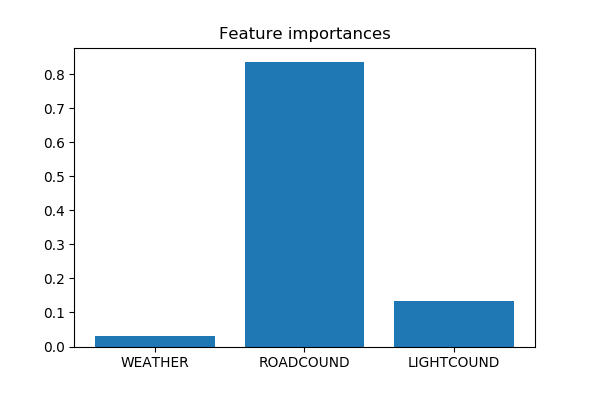

In [198]:
fi=tree.feature_importances_
x=['WEATHER', 'ROADCOUND', 'LIGHTCOUND']
plt.figure()
plt.title('Feature importances')
plt.bar(x=x, height=fi)
plt.show()

<IPython.core.display.Javascript object>


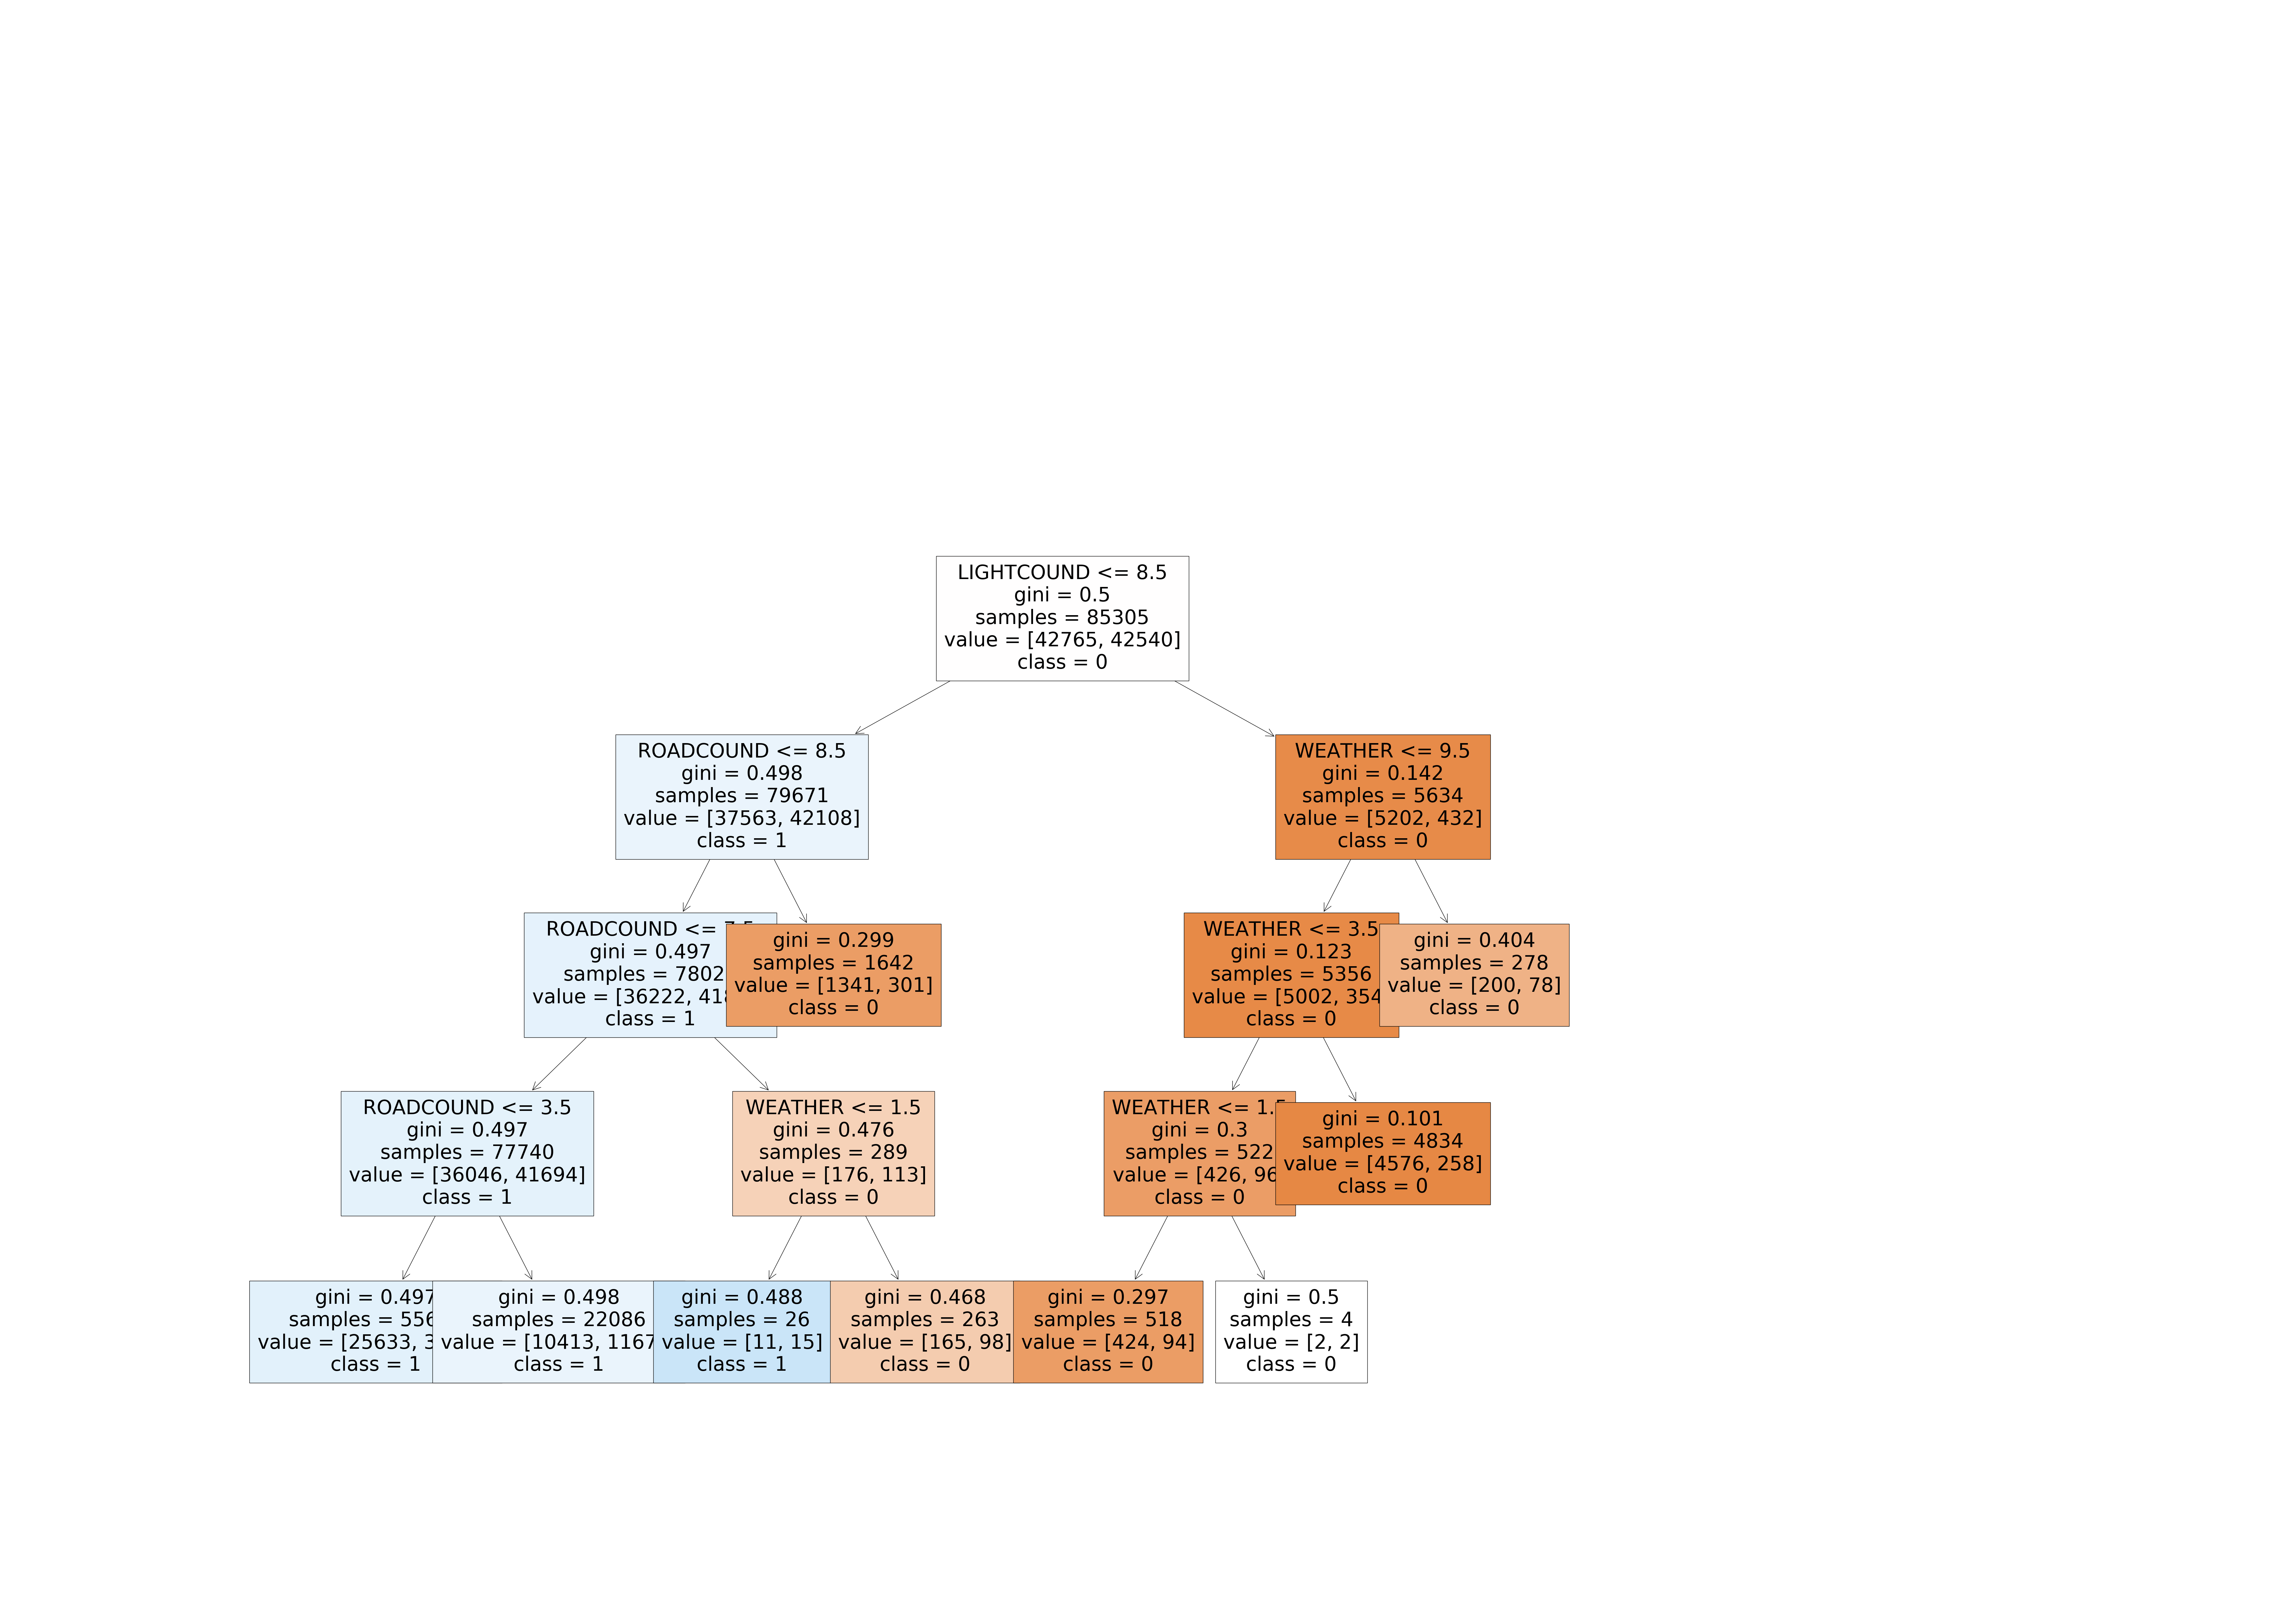

In [186]:
fig = plt.figure(figsize=(70,50))
_ = plot_tree(tree, 
                   feature_names=x,  
                   class_names=['0','1'],
                   filled=True)

As we can observe **light conditions** has the most impact on severity.


## Results and Discussion

In this project I've built the machine learning model, that can predict severety of possible road accidend based weather conditions. The data I used was .csv file with description of road accidents in Seatlle city.

After preprocessing of the data I decided to use as target values SEVERNETYCODE column that contains two types of coded values:
1. Property damage
2. Injury

As an atributes a choose WEATHER, ROADCOND, LIGHTCOND. The last two columns has information directly related to the weather conditions. 

Then I've formated the data suitable for machine learning. I've run couple of ML models can handle binary calsificatin with large dataset. The best output gave DesidionTreeClassifier. Then I've opimized this model using grid seach tool. As performans indicators I've used accuracy and recall. Model reached accuracy of *57.2%* and recall of *98%*. As most important feature for calssification model choosed light conditions.

## Сonclusion

Despite the fact that model did't reached hight generalization performance. It have shown that light condition is highly correlated with severity that weather in general. 
Model of such type can be used by emergency services for provisional allocation of ambulance teams in regions with wether that increace chance of road accidens with injured.

Also this project has shown that data about weather condition does not enough to predict severity of the collision with hight accuracy. In further researches other factors of severity need to be finded

Another conclusion I can make, that emergency services should gather and rely more on data about light and road condition than just weather when predicting severe road accidents.